# Agentic RAG From Scratch: Building with LangGraph and Anthropic Claude

> **Note:** While this notebook can be adapted to use various LLM providers, we'll be using the Anthropic Claude API. Please follow the best practices outlined in the [SRHG AI Usage Guidelines](https://srhg.enterprise.slack.com/docs/T0HANKTEC/F0AB86J3A1L).

In this notebook, we'll look under the hood of `create_agent` and build an agentic RAG application **from scratch** using LangGraph's low-level primitives. We'll build a **Stone Ridge Investment Assistant** that can answer questions about Stone Ridge's investment philosophy, market insights, and strategic outlook.

**Learning Objectives:**
- Understand LangGraph's core constructs: StateGraph, nodes, edges, and conditional routing
- Build a ReAct agent from scratch without high-level abstractions
- Use Anthropic Claude for powerful reasoning and generation
- Set up LangSmith tracing for observability and debugging
- Transition from `aimakerspace` utilities to the LangChain ecosystem

## Table of Contents:

- **Part 1:** LangGraph Fundamentals & Building Agents from Scratch
  - Task 1: Dependencies & Setup
  - Task 2: Environment Variables & LangSmith Tracing
  - Task 3: LangGraph Core Concepts (StateGraph, Nodes, Edges)
  - Task 4: Building a ReAct Agent from Scratch
  - Task 5: Adding Tools to Your Agent
  - Question #1 & Question #2
  - Activity #1: Implement a Custom Routing Function

- **Part 2:** Agentic RAG with Anthropic Claude
  - Task 6: Loading & Chunking with LangChain
  - Task 7: Setting up Qdrant with OpenAI Embeddings
  - Task 8: Creating a RAG Tool
  - Task 9: Building Agentic RAG from Scratch
  - Task 10: Comparing Traces in LangSmith
  - Question #3 & Question #4
  - Activity #2: Extend the Agent with Memory

---
# Part 1
## LangGraph Fundamentals & Building Agents from Scratch

## Task 1: Dependencies & Setup

Before we begin, make sure you have your API keys ready:

1. **Anthropic API Key** - For Claude chat models
2. **OpenAI API Key** - For embeddings (text-embedding-3-small)
3. **LangSmith API Key** (optional) - For tracing and observability

**📚 Documentation:**
- [Anthropic API Documentation](https://docs.anthropic.com/)
- [LangChain-Anthropic Integration](https://python.langchain.com/docs/integrations/chat/anthropic/)
- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)

In [12]:
# Core imports we'll use throughout the notebook
import os
import getpass
import json
from uuid import uuid4
from typing import Annotated, TypedDict, Literal

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

# Set up API keys
# os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Anthropic API Key: ")
# os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key (for embeddings): ")

In [13]:
# Verify Anthropic connection
from langchain_anthropic import ChatAnthropic
# from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings

# Test connection to Anthropic
try:
    test_llm = ChatAnthropic(model="claude-sonnet-4-20250514", temperature=0)
    test_response = test_llm.invoke("Say 'Claude is working!' in exactly 3 words.")
    print(f"Chat Model Test: {test_response.content}")
    
    # test_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    test_embeddings = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2")
    test_vector = test_embeddings.embed_query("test")
    print(f"Embedding Model Test: Vector dimension = {len(test_vector)}")
    print("\nAnthropic Claude and OpenAI Embeddings are ready!")
except Exception as e:
    print(f"Error connecting to APIs: {e}")
    print("\nMake sure your API keys are correct.")

Chat Model Test: Claude is working!
Embedding Model Test: Vector dimension = 768

Anthropic Claude and OpenAI Embeddings are ready!


## Task 2: LangGraph Core Concepts

In Module 3, we used `create_agent` which abstracts away the complexity. Now let's understand what's happening under the hood!

### LangGraph models workflows as **graphs** with three key components:

### 1. State
A shared data structure that represents the current snapshot of your application:

```python
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]  # Conversation history
```

The `add_messages` **reducer** ensures new messages are appended (not replaced) when the state updates.

### 2. Nodes
Python functions that encode the logic of your agent:
- Receive the current state
- Perform computation or side-effects
- Return an updated state

### 3. Edges
Functions that determine which node to execute next:
- **Normal edges**: Always go to a specific node
- **Conditional edges**: Choose the next node based on state

**📚 Documentation:**
- [LangGraph Low-Level Concepts](https://langchain-ai.github.io/langgraph/concepts/low_level/)
- [LangGraph Quickstart](https://langchain-ai.github.io/langgraph/tutorials/introduction/)
- [StateGraph API Reference](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph)

In [14]:
# Let's build our first LangGraph workflow - a simple echo graph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage

# Step 1: Define the State
class SimpleState(TypedDict):
    messages: Annotated[list, add_messages]

# Step 2: Define Nodes (functions that process state)
def echo_node(state: SimpleState):
    """A simple node that echoes the last message."""
    last_message = state["messages"][-1]
    echo_response = AIMessage(content=f"You said: {last_message.content}")
    return {"messages": [echo_response]}

# Step 3: Build the Graph
echo_graph = StateGraph(SimpleState)

# Add nodes
echo_graph.add_node("echo", echo_node)

# Add edges (START -> echo -> END)
echo_graph.add_edge(START, "echo")
echo_graph.add_edge("echo", END)

# Compile the graph
echo_app = echo_graph.compile()

print("Simple echo graph created!")

Simple echo graph created!


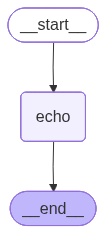

In [15]:
# Visualize the graph structure
try:
    from IPython.display import display, Image
    display(Image(echo_app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure (ASCII):")
    print(echo_app.get_graph().draw_ascii())

In [16]:
# Test the echo graph
result = echo_app.invoke({"messages": [HumanMessage(content="Hello, LangGraph!")]})

print("Conversation:")
for msg in result["messages"]:
    role = "Human" if isinstance(msg, HumanMessage) else "AI"
    print(f"  [{role}]: {msg.content}")

Conversation:
  [Human]: Hello, LangGraph!
  [AI]: You said: Hello, LangGraph!


## Task 3: Building a ReAct Agent from Scratch

Now let's build something more sophisticated: a **ReAct agent** that can:
1. **Reason** about what to do
2. **Act** by calling tools
3. **Observe** results
4. **Repeat** until done

This is exactly what `create_agent` does under the hood. Let's build it ourselves!

### The Agent Loop Architecture

```
                    ┌──────────────┐
                    │    START     │
                    └──────┬───────┘
                           │
                           ▼
                    ┌──────────────┐
             ┌─────►│    agent     │◄────────┐
             │      │  (call LLM)  │         │
             │      └──────┬───────┘         │
             │             │                 │
             │             ▼                 │
             │      ┌──────────────┐         │
             │      │ should_      │         │
             │      │ continue?    │         │
             │      └──────┬───────┘         │
             │             │                 │
             │    tool_calls?                │
             │     │           │             │
             │    YES         NO             │
             │     │           │             │
             │     ▼           ▼             │
             │ ┌────────┐  ┌───────┐         │
             │ │ tools  │  │  END  │         │
             └─┤(execute│  └───────┘         │
               │ tools) ├────────────────────┘
               └────────┘
```

**📚 Documentation:**
- [How to create a ReAct agent from scratch](https://langchain-ai.github.io/langgraph/how-tos/react-agent-from-scratch/)
- [ReAct Agent Conceptual Guide](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-agent)

In [17]:
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

# Step 1: Define the Agent State
class AgentState(TypedDict):
    """The state of our agent - just a list of messages."""
    messages: Annotated[list[BaseMessage], add_messages]

print("AgentState defined with messages field")

AgentState defined with messages field


In [18]:
# Step 2: Initialize our LLM with Anthropic Claude
llm = ChatAnthropic(
    model="claude-sonnet-4-20250514",
    temperature=0,  # Deterministic for reproducibility
)

print(f"LLM initialized: {llm.model}")

LLM initialized: claude-sonnet-4-20250514


## Task 4: Adding Tools to Your Agent

Tools are functions that the agent can call. We use the `@tool` decorator and **bind** them to the LLM.

**📚 Documentation:**
- [LangChain Tools Conceptual Guide](https://python.langchain.com/docs/concepts/tools/)
- [@tool Decorator Reference](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.convert.tool.html)
- [ToolNode Prebuilt](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode)
- [Anthropic Tool Use](https://docs.anthropic.com/en/docs/build-with-claude/tool-use)

In [19]:
# Step 3: Define Tools
@tool
def calculate(expression: str) -> str:
    """Evaluate a mathematical expression. Use this for any math calculations.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., '2 + 2', '10 * 5')
    """
    try:
        # Using eval with restricted globals for safety
        result = eval(expression, {"__builtins__": {}}, {})
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error evaluating expression: {e}"

@tool
def get_current_time() -> str:
    """Get the current date and time. Use this when the user asks about the current time or date."""
    from datetime import datetime
    return f"The current date and time is: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

# Create our tool list
tools = [calculate, get_current_time]

# Bind tools to the LLM - this tells the LLM about available tools
llm_with_tools = llm.bind_tools(tools)

print("Tools defined and bound to LLM:")
for t in tools:
    print(f"  - {t.name}: {t.description[:50]}...")

Tools defined and bound to LLM:
  - calculate: Evaluate a mathematical expression. Use this for a...
  - get_current_time: Get the current date and time. Use this when the u...


In [49]:
# Step 4: Define the Agent Node (calls the LLM)
SYSTEM_PROMPT = """You are a helpful assistant that can perform calculations and tell the time.
Always use the available tools when appropriate.
Be concise in your responses."""

def agent_node(state: AgentState):
    """The agent node - calls the LLM with the current conversation."""
    # Prepare messages with system prompt
    messages = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]
    
    # Call the LLM
    response = llm_with_tools.invoke(messages)
    
    # Return the response to be added to state
    return {"messages": [response]}

print("Agent node defined")

Agent node defined


In [50]:
# Step 5: Define the Tool Node (executes tools)
# We can use LangGraph's prebuilt ToolNode for convenience
tool_node = ToolNode(tools)

print("Tool node created using ToolNode prebuilt")

Tool node created using ToolNode prebuilt


In [25]:
# Step 6: Define the Conditional Edge (routing logic)
def should_continue(state: AgentState) -> Literal["tools", "end"]:
    """Determine whether to call tools or end the conversation."""
    last_message = state["messages"][-1]

    # If the LLM made tool calls, route to tools node
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # Otherwise, end the conversation
    return "end"

print("Conditional routing function defined")

Conditional routing function defined


In [26]:
# Step 7: Build the Graph!
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("agent", agent_node)
workflow.add_node("tools", tool_node)

# Set the entry point
workflow.add_edge(START, "agent")

# Add conditional edge from agent
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",  # If should_continue returns "tools", go to tools node
        "end": END         # If should_continue returns "end", finish
    }
)

# Add edge from tools back to agent (the loop!)
workflow.add_edge("tools", "agent")

# Compile the graph
agent = workflow.compile()

print("ReAct agent built from scratch!")

NameError: name 'agent_node' is not defined

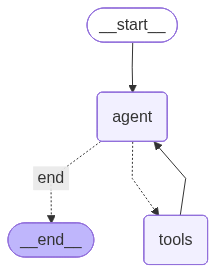

In [53]:
# Visualize our agent
try:
    from IPython.display import display, Image
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure (ASCII):")
    print(agent.get_graph().draw_ascii())

In [54]:
# Test our agent!
print("Testing our from-scratch agent:")
print("=" * 50)

response = agent.invoke({"messages": [HumanMessage(content="What is 25 * 48?")]})

print("\nConversation:")
for msg in response["messages"]:
    msg_type = type(msg).__name__
    content = msg.content if msg.content else f"[Tool calls: {msg.tool_calls}]" if hasattr(msg, 'tool_calls') and msg.tool_calls else "[No content]"
    print(f"  [{msg_type}]: {content[:200]}")

Testing our from-scratch agent:
yoo yo yoyo

Conversation:
  [HumanMessage]: What is 25 * 48?
  [AIMessage]: [{'id': 'tooluse_KRBVDDKiDkDErdmlvP5Rej', 'input': {'expression': '25 * 48'}, 'name': 'calculate', 'type': 'tool_use'}]
  [ToolMessage]: The result of 25 * 48 is 1200
  [AIMessage]: 25 * 48 = **1200**


In [55]:
# Test with multiple tools
print("Testing with multiple tool calls:")
print("=" * 50)

response = agent.invoke({
    "messages": [HumanMessage(content="What time is it, and what is 100 divided by the current hour?")]
})

print("\nFinal response:")
print(response["messages"][-1].content)

Testing with multiple tool calls:
yoo yo yoyo

Final response:
The current time is **17:01:03** (5:01 PM), and 100 divided by the current hour (17) equals approximately **5.88**.


In [20]:
# Stream the agent's execution to see it step by step
print("Streaming agent execution:")
print("=" * 50)

for chunk in agent.stream(
    {"messages": [HumanMessage(content="Calculate 15% of 200")]},
    stream_mode="updates"
):
    for node_name, values in chunk.items():
        print(f"\n[Node: {node_name}]")
        if "messages" in values:
            for msg in values["messages"]:
                if hasattr(msg, 'content') and msg.content:
                    print(f"  Content: {msg.content[:200]}")
                if hasattr(msg, 'tool_calls') and msg.tool_calls:
                    print(f"  Tool calls: {[tc['name'] for tc in msg.tool_calls]}")

Streaming agent execution:

[Node: agent]
  Content: [{'id': 'tooluse_JwpFckGr33KvefNAU7GcDU', 'input': {'expression': '0.15 * 200'}, 'name': 'calculate', 'type': 'tool_use'}]
  Tool calls: ['calculate']

[Node: tools]
  Content: The result of 0.15 * 200 is 30.0

[Node: agent]
  Content: 15% of 200 is **30**.


---
## ❓ Question #1:

In our from-scratch agent, we defined a `should_continue` function that returns either `"tools"` or `"end"`. How does this compare to how `create_agent` handles the same decision? What additional logic might `create_agent` include that we didn't implement?

##### Answer:
We just check if there are any tool calls in the agent's response, if not we dont continue. The create_agent seems to do a better job with error checking and handling, like potentially telling the llm if there is an error in teh tool. It also handles for structured ouput tools and tools that explicilty say to return directly. It also seems to be handling for a situation where the model jumps to the end automatically

## ❓ Question #2:

We used `ToolNode` from `langgraph.prebuilt` to execute tools. Looking at the tool execution flow, what would happen if we wanted to add logging, error handling, or rate limiting to tool execution? How would building our own tool node give us more control?

##### Answer:
My inclination would be you can probably do all this within the ToolNode or the tool itself. For example you could put rate limiting within/logging the tool code itself. We could also handle exceptions via the fairly robust options in "handle_tool_errors". I can imagine something like creating a custome exception type "RateLimitExceeded" and passing into the handle_tool_errors a callable that handles that exception and returns an appropriate response. This could get a little verbose so I think if i were to do this I would probably inherit the ToolNode class and override the execute methods

---
## 🏗️ Activity #1: Implement a Custom Routing Function

Extend the agent by implementing a **custom routing function** that adds more sophisticated logic.

Ideas:
- Add a maximum iteration limit to prevent infinite loops
- Route to different nodes based on the type of tool being called
- Add a "thinking" step before tool execution

Requirements:
1. Modify the `should_continue` function or create a new one
2. Add any new nodes if needed
3. Rebuild and test the agent

**📚 Documentation:**
- [Conditional Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges)
- [How to create branches for parallel node execution](https://langchain-ai.github.io/langgraph/how-tos/branching/)

In [1]:
### YOUR CODE HERE ###

# Example: Add iteration tracking to prevent infinite loops
class AgentStateWithCounter(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    iteration_count: int

print("Conditional routing function defined")


class TrojanHorseException(Exception):
    pass
    
@tool
def calculate(expression: str) -> str:
    """Evaluate a mathematical expression. Use this for any math calculations.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., '2 + 2', '10 * 5')
    """
    raise TrojanHorseException()

@tool
def calculate2(expression: str) -> str:
    """Another way to evaluate a mathematical expression. Use this for any math calculations.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., '2 + 2', '10 * 5')
    """
    try:
        # Using eval with restricted globals for safety
        result = eval(expression, {"__builtins__": {}}, {})
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error evaluating expression: {e}"

def handle_tool_errors_local(e: TrojanHorseException):
    return "the calculate tool is a bad tool that always throws, try again with the other_tool with the exact same args"
    
tool_node = ToolNode([calculate, other_tool, get_current_time], handle_tool_errors=handle_tool_errors_local)
def custom_should_continue(state: AgentStateWithCounter) -> Literal["tools", "end"]:
    print(state)
    """Custom routing with iteration limit."""
    # Your implementation here
    print(f"Through {state['iteration_count']} steps")
    if state['iteration_count'] > 2:
        return "end"

    return should_continue(state)

# Build your custom agent

# Step 7: Build the Graph!
workflow = StateGraph(AgentStateWithCounter)

def agent_node(state: AgentStateWithCounter):
    """The agent node - calls the LLM with the current conversation."""
    # Prepare messages with system prompt
    messages = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]
    
    # Call the LLM
    response = llm_with_tools.invoke(messages)
    
    # Return the response to be added to state
    return {
        "messages": [response],
        # "iteration_count": 1 + state['iteration_count']
    }

def iterator_node(state):
    return {"iteration_count": 1 + state['iteration_count']}

# Add nodes
workflow.add_node("agent", agent_node)
workflow.add_node("loop_iter", iterator_node)
workflow.add_node("tools", tool_node)

# Set the entry point
workflow.add_edge(START, "loop_iter")
workflow.add_edge("loop_iter", "agent")

# Add conditional edge from agent
workflow.add_conditional_edges(
    "agent",
    custom_should_continue,
    {
        "tools": "tools",  # If should_continue returns "tools", go to tools node
        "end": END         # If should_continue returns "end", finish
    }
)

# Add edge from tools back to agent (the loop!)
workflow.add_edge("tools", "loop_iter")

# Compile the graph
agent = workflow.compile()

print("ReAct agent built from scratch!")

NameError: name 'TypedDict' is not defined

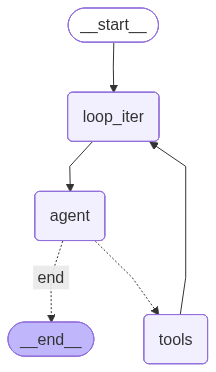

In [114]:
agent

In [115]:
# Test your custom agent
# Stream the agent's execution to see it step by step
print("Streaming agent execution:")
print("=" * 50)

for chunk in agent.stream(
    {
        "messages": [HumanMessage(content="is 3 a factor of the current year to the 7th power plus 77")],
        "iteration_count": 0
    },
    stream_mode="updates"
):
    for node_name, values in chunk.items():
        print(f"\n[Node: {node_name}]")
        if "messages" in values:
            for msg in values["messages"]:
                if hasattr(msg, 'content') and msg.content:
                    print(f"  Content: {msg.content[:200]}")
                if hasattr(msg, 'tool_calls') and msg.tool_calls:
                    print(f"  Tool calls: {[tc['name'] for tc in msg.tool_calls]}")

Streaming agent execution:

[Node: loop_iter]
{'messages': [HumanMessage(content='is 3 a factor of the current year to the 7th power plus 77', additional_kwargs={}, response_metadata={}, id='74b143bc-e7a1-4de0-be4c-1aaff515c297'), AIMessage(content=[{'text': "I'll help you determine if 3 is a factor of (current year)^7 + 77.\n\nFirst, let me get the current year:", 'type': 'text'}, {'id': 'tooluse_agO8RR0i8qQDeky5rXnyol', 'input': {}, 'name': 'get_current_time', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_19c4aab6ad09efea42a', 'model': 'us.anthropic.claude-sonnet-4-5-20250929-v1:0', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation': None, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'inference_geo': None, 'input_tokens': 702, 'output_tokens': 73, 'server_tool_use': None, 'service_tier': None}, 'model_name': 'us.anthropic.claude-sonnet-4-5-20250929-v1:0', 'model_provider': 'anthropic'}, id='lc_run--019c4aab-6273

---
# Part 2
## Agentic RAG with Local Models

Now let's build a full **Agentic RAG** system from scratch using Anthropic Claude!

We'll transition from the `aimakerspace` utilities to the **LangChain ecosystem**:

| Task | aimakerspace | LangChain |
|------|--------------|----------|
| Load Documents | `PDFFileLoader` | `PyMuPDFLoader` |
| Split Text | `CharacterTextSplitter` | `RecursiveCharacterTextSplitter` |
| Embeddings | Custom | `OpenAIEmbeddings` |
| Chat Model | - | `ChatAnthropic` |

## Task 5: Loading & Chunking with LangChain

Let's use LangChain's document loaders and text splitters to load the Stone Ridge 2025 Investor Letter.

**📚 Documentation:**
- [Document Loaders Conceptual Guide](https://python.langchain.com/docs/concepts/document_loaders/)
- [PyMuPDFLoader Reference](https://python.langchain.com/docs/integrations/document_loaders/pymupdf/)
- [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/)
- [Text Splitters Conceptual Guide](https://python.langchain.com/docs/concepts/text_splitters/)

In [1]:
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load the Stone Ridge investor letter using PyMuPDFLoader
loader = PyMuPDFLoader("data/Stone Ridge 2025 Investor Letter.pdf")
documents = loader.load()

print(f"Loaded {len(documents)} page(s)")
print(f"Total characters: {sum(len(doc.page_content) for doc in documents):,}")
print(f"\nFirst page metadata: {documents[0].metadata}")

Loaded 14 page(s)
Total characters: 52,924

First page metadata: {'producer': 'Adobe PDF Library 18.0', 'creator': 'Adobe InDesign 21.0 (Windows)', 'creationdate': '2026-01-02T10:35:45-05:00', 'source': 'data/Stone Ridge 2025 Investor Letter.pdf', 'file_path': 'data/Stone Ridge 2025 Investor Letter.pdf', 'total_pages': 14, 'format': 'PDF 1.4', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2026-01-02T10:35:48-05:00', 'trapped': '', 'modDate': "D:20260102103548-05'00'", 'creationDate': "D:20260102103545-05'00'", 'page': 0}


In [6]:
# Split documents using RecursiveCharacterTextSplitter
# This is more sophisticated than simple character splitting!
# documents = [d.split('Endnotes')[0] for d in documents]
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    length_function=len,
    # Default separators: ["\n\n", "\n", " ", ""]
    # Tries to keep paragraphs, then sentences, then words together
)

chunks = text_splitter.split_documents(documents)

print(f"Split into {len(chunks)} chunks")
print(f"\nSample chunk (first 300 chars):")
print("-" * 50)
print(chunks[0].page_content[:300] + "...")

Split into 127 chunks

Sample chunk (first 300 chars):
--------------------------------------------------
2025 Investor Letter...


## Task 6: Setting up Qdrant with OpenAI Embeddings

Now we'll use **OpenAI Embeddings** with `text-embedding-3-small` - a high-quality embedding model that works well for financial documents.

**📚 Documentation:**
- [OpenAI Embeddings Reference](https://python.langchain.com/docs/integrations/text_embedding/openai/)
- [Qdrant Vector Store Integration](https://python.langchain.com/docs/integrations/vectorstores/qdrant/)
- [Embedding Models Conceptual Guide](https://python.langchain.com/docs/concepts/embedding_models/)

In [7]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Initialize OpenAI embedding model
model_name = "all-mpnet-base-v2"
embedding_model = HuggingFaceEmbeddings(model_name=model_name)

# Get embedding dimension
sample_embedding = embedding_model.embed_query("test")
embedding_dim = len(sample_embedding)
print(f"Embedding dimension: {embedding_dim}")
print(f"Using model: text-embedding-3-small")

Embedding dimension: 768
Using model: text-embedding-3-small


In [8]:
# Create Qdrant client (in-memory for development)
qdrant_client = QdrantClient(":memory:")

# Create a collection for our investment documents
collection_name = "investment_knowledge_base"

qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(
        size=embedding_dim,
        distance=Distance.COSINE
    )
)

print(f"Created collection: {collection_name}")

Created collection: investment_knowledge_base


In [9]:
# Create vector store and add documents
vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=collection_name,
    embedding=embedding_model
)

# Add documents to the vector store
print("Adding documents to vector store...")
vector_store.add_documents(chunks)
print(f"Added {len(chunks)} documents to vector store")

Adding documents to vector store...
Added 127 documents to vector store


In [20]:
# Test the retriever
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

test_results = retriever.invoke("What is Stone Ridge's investment philosophy?")

print("Retrieved documents:")
for i, doc in enumerate(test_results, 1):
    print(f"\n--- Document {i} ---")
    print(doc.page_content[:200] + "...")

Retrieved documents:

--- Document 1 ---
investor?  At Stone Ridge, we do not pull our phones out on each other.
With Stone Ridge increasingly Stone Ridge’s largest investor, the scale of our profits as principals, not agents, creates 
a lev...

--- Document 2 ---
or referenced herein and does not represent a formal or official view of Stone Ridge.
It should not be assumed that Stone Ridge will make investment recommendations in the future that are consistent w...

--- Document 3 ---
Earlier this year, Stone Ridge Holdings Group (SRHG), parent company of Stone Ridge Asset Management, NYDIG, 
and Longtail Re, completed a significant primary equity financing led by an iconic America...


## Task 7: Creating a RAG Tool

Now let's wrap our retriever as a tool that the agent can use to search Stone Ridge's investor letters.

In [21]:
@tool
def search_investment_knowledge(query: str) -> str:
    """Search the Stone Ridge investment knowledge base for information about investment philosophy, market insights, and strategic outlook.
    
    Use this tool when the user asks questions about:
    - Stone Ridge's investment philosophy and approach
    - Market analysis and insights from investor letters
    - Strategic outlook and portfolio positioning
    - Company updates and business developments
    - Historical performance context and investment themes
    
    Args:
        query: The search query to find relevant investment information
    """
    results = retriever.invoke(query)
    
    if not results:
        return "No relevant information found in the investment knowledge base."
    
    # Format the results
    formatted_results = []
    for i, doc in enumerate(results, 1):
        formatted_results.append(f"[Source {i}]:\n{doc.page_content}")
    
    return "\n\n".join(formatted_results)

print(f"RAG tool created: {search_investment_knowledge.name}")

RAG tool created: search_investment_knowledge


## Task 8: Building Agentic RAG from Scratch

Now let's put it all together - a complete agentic RAG system built from scratch using Anthropic Claude!

In [32]:
# Define all tools for our RAG agent
rag_tools = [search_investment_knowledge, calculate, get_current_time]

# Bind tools to the LLM
rag_llm_with_tools = llm.bind_tools(rag_tools)

print("Tools for RAG agent:")
for t in rag_tools:
    print(f"  - {t.name}")

Tools for RAG agent:
  - search_investment_knowledge
  - calculate
  - get_current_time


In [33]:
# Define the RAG agent components
RAG_SYSTEM_PROMPT = """You are a helpful Stone Ridge investment assistant with access to a comprehensive knowledge base of investor letters and company information.

Your role is to:
1. Answer questions about Stone Ridge's investment philosophy, market insights, and strategic outlook
2. ALWAYS search the knowledge base when the user asks investment-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be professional and informative in your responses
5. If you cannot find relevant information, say so honestly
6. Include a reminder that information is for educational purposes only and not investment advice when appropriate

Remember: Always cite information from the knowledge base when applicable."""

def rag_agent_node(state: AgentState):
    """The RAG agent node - calls the LLM with investment system prompt."""
    messages = [SystemMessage(content=RAG_SYSTEM_PROMPT)] + state["messages"]
    response = rag_llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Create tool node for RAG tools
rag_tool_node = ToolNode(rag_tools)

print("RAG agent node defined")

RAG agent node defined


In [34]:
# Build the RAG agent graph
rag_workflow = StateGraph(AgentState)

# Add nodes
rag_workflow.add_node("agent", rag_agent_node)
rag_workflow.add_node("tools", rag_tool_node)

# Set entry point
rag_workflow.add_edge(START, "agent")

# Add conditional edge
rag_workflow.add_conditional_edges(
    "agent",
    should_continue,
    {"tools": "tools", "end": END}
)

# Add edge from tools back to agent
rag_workflow.add_edge("tools", "agent")

# Compile
rag_agent = rag_workflow.compile()

print("Agentic RAG built from scratch!")

Agentic RAG built from scratch!


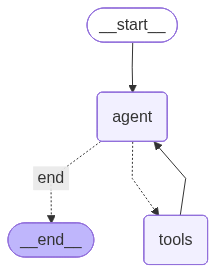

In [35]:
# Visualize the RAG agent
try:
    from IPython.display import display, Image
    display(Image(rag_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure:")
    print(rag_agent.get_graph().draw_ascii())

In [29]:
# Test the RAG agent
print("Testing Agentic RAG (with Anthropic Claude):")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(content="What is Stone Ridge's investment philosophy?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Agentic RAG (with Anthropic Claude):

Final Response:
Based on the Stone Ridge investor letters, here are the key elements of **Stone Ridge's investment philosophy**:

## Core Principles

**1. Principal, Not Agent**
Stone Ridge operates as principals investing their own capital alongside outside investors, rather than as agents simply managing others' money. With Stone Ridge being its own largest investor, this creates exceptional alignment with outside investors—a distinction that clients describe as "wonderfully clarifying and palpable."

**2. Focus on After-Tax Cash Flow**
The firm relentlessly focuses on growing after-tax cash flow to drive durable equity value in their operating businesses. They acknowledge that progress doesn't follow a straight line, and they embrace that reality.

**3. Bayesian Thinking and Rapid Updating**
Stone Ridge emphasizes:
- Thinking deeply about what they know before they know it
- Open-mindedness to and hunger for new data
- Extremely rapid po

In [30]:
# Test with a complex query requiring both RAG and calculation
print("Testing with complex query:")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(
        content="What does Stone Ridge say about their energy investments? Also, if they invested $100 million with a 50% annual return, what would be the total after 1 year?"
    )]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing with complex query:

Final Response:
Great! Here's what I found:

## Stone Ridge's Energy Investments

Stone Ridge has shared several key insights about their energy franchise:

**Key Learnings:**
- When launching their energy franchise almost 5 years ago, Stone Ridge initially believed their breakthroughs in proprietary financing and hedging technology would be sufficient for best-in-class performance
- However, they learned an important lesson: **"financial sophistication cannot substitute for industrial control"** - in energy markets, physics (not finance) sets the terms
- After this realization, they partnered with **Flywheel Energy**, which they describe as "by far the best operators in" the space

**Performance & Scale:**
- Stone Ridge Energy (SRE) has purchased almost **$11 billion of energy assets** since inception
- All purchases were made via proprietary securitizations with no bankers, no information leakage, and no fee leakage
- Despite natural gas prices ranging vo

In [31]:
# Test that the agent knows when NOT to use RAG
print("Testing agent decision-making (should NOT use RAG):")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(content="What is 125 * 8?")]
})

print("\nFinal Response:")
print(response["messages"][-1].content)

Testing agent decision-making (should NOT use RAG):

Final Response:
125 × 8 = **1,000**


---
## ❓ Question #3:

Compare the experience of building an agent from scratch with LangGraph versus using `create_agent` from Module 3. What are the trade-offs between control and convenience? When would you choose one approach over the other for a Stone Ridge investment assistant?

##### Answer:
langchain's create_agent is a really nice tool that wraps waht I imagine is 95% of functionality an average user could possibly want. In theory one could do some custom agent routing based on tool output or building more sophisticated middleware that maybe doesn't fit into the specific params of langchain. That said langraph seems pretty strict. I tried adding a random node after my agent before tool that added some mdetadata and it failed saying it needed a tool response. I'm sure one day I'll run itno a use case for building a beautiful complicated graph taht I can't express in langchain, but I'm not there yet.

## ❓ Question #4:

We used Anthropic Claude for reasoning and OpenAI for embeddings. What are the considerations when choosing different providers for different tasks in an AI application? How might these choices impact a production investment assistant?

##### Answer:
From personal experience, i've found htat different models for embedding has a massive effect on the quality of rag context results. For example i started with a model that had way too few dimensions and my search results were garbage. Reegarding choosing differernt models for the agent parts of the workflow, i'm sure different agents are fine tuned for different things so there is probably a lot of learning to be done for different tiyipes of tasks (for example doing some sort of image generation is presumably miles away from doing math problems). Another consideration which I think is exteremely important is cost. Avoiding the most sophisticated task for a simple agent is probably a smart idea if you have any line of site to the CFO.

I've also seen some pretty interesting stuff with snowflake where you can use a sophisticated model to create input output patterns, then train a cheaper model on those patterns to optimize costs for specific workflows, this seemed like a pretty cool pattern.

---
## 🏗️ Activity #2: Extend the Agent with Memory

LangGraph supports **checkpointing** which enables conversation memory across invocations.

Your task: Add memory to the RAG agent so it can:
1. Remember previous questions in the conversation
2. Reference past context when answering new questions
3. Build on previous answers

Hint: Use `MemorySaver` from `langgraph.checkpoint.memory` and pass a `thread_id` in the config.

**📚 Documentation:**
- [LangGraph Persistence & Memory](https://langchain-ai.github.io/langgraph/concepts/persistence/)
- [How to add memory to your graph](https://langchain-ai.github.io/langgraph/how-tos/persistence/)
- [MemorySaver Reference](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver)

In [52]:
### YOUR CODE HERE ###

from langgraph.checkpoint.memory import MemorySaver

# Create a memory saver
memory = MemorySaver()

# Recompile the agent with checkpointing
# rag_agent_with_memory = rag_workflow.compile(checkpointer=memory)

# Test with a conversation that requires memory
# Use config={"configurable": {"thread_id": "conversation-1"}}


In [53]:
# Define the RAG agent components
RAG_SYSTEM_PROMPT = """You are a helpful Stone Ridge investment assistant with access to a comprehensive knowledge base of investor letters and company information.

Your role is to:
1. Answer questions about Stone Ridge's investment philosophy, market insights, and strategic outlook
2. ALWAYS search the knowledge base when the user asks investment-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be professional and informative in your responses
5. If you cannot find relevant information, say so honestly
6. Include a reminder that information is for educational purposes only and not investment advice when appropriate

Remember: Always cite information from the knowledge base when applicable."""

def rag_agent_node(state: AgentState):
    """The RAG agent node - calls the LLM with investment system prompt."""
    messages = [SystemMessage(content=RAG_SYSTEM_PROMPT)] + state["messages"]
    response = rag_llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Create tool node for RAG tools
rag_tool_node = ToolNode(rag_tools)

print("RAG agent node defined")
# Build the RAG agent graph
rag_workflow = StateGraph(AgentState)

# Add nodes
rag_workflow.add_node("agent", rag_agent_node)
rag_workflow.add_node("tools", rag_tool_node)

# Set entry point
rag_workflow.add_edge(START, "agent")

# Add conditional edge
rag_workflow.add_conditional_edges(
    "agent",
    should_continue,
    {"tools": "tools", "end": END}
)

# Add edge from tools back to agent
rag_workflow.add_edge("tools", "agent")

# Compile
rag_agent = rag_workflow.compile(checkpointer=memory)

print("Agentic RAG built from scratch!")

RAG agent node defined
Agentic RAG built from scratch!


In [54]:
# Test your memory-enabled agent with a multi-turn conversation

# Test that the agent knows when NOT to use RAG
print("Testing agent decision-making (should NOT use RAG):")
print("=" * 50)

response = rag_agent.invoke(
    {
        "messages": [HumanMessage(content="What is 125 * 8?")]
    },
    config={
        'thread_id': 'c1'
    }
)

print("\nFinal Response:")
print(response["messages"][-1].content)

Testing agent decision-making (should NOT use RAG):

Final Response:
125 × 8 = **1,000**


In [56]:

response = rag_agent.invoke(
    {
        "messages": [HumanMessage(content="What was the answer to the math question i asked you recently?")]
    },
    config={
        'thread_id': 'c1'
    }
)

print("\nFinal Response:")
print(response["messages"][-1].content)


Final Response:
The answer to the math question you asked me recently was **1,000**.

You asked me to calculate 125 × 8, which equals 1,000.


In [57]:

response = rag_agent.invoke(
    {
        "messages": [HumanMessage(content="What was the answer to the math question i asked you recently?")]
    },
    config={
        'thread_id': 'c3'
    }
)

print("\nFinal Response:")
print(response["messages"][-1].content)


Final Response:
I don't have any record of a previous math question from you in our current conversation. This appears to be the start of our conversation, so I don't have access to any earlier exchanges we may have had.

If you'd like to ask me a math question now, I'd be happy to help you calculate it! Just let me know what you'd like me to work out.


---
## Summary

In this module, we:

1. **Built agents from scratch** using LangGraph's low-level primitives (StateGraph, nodes, edges)
2. **Used Anthropic Claude** for powerful reasoning and generation
3. **Transitioned to LangChain** for document loading and text splitting
4. **Set up observability** with LangSmith tracing
5. **Created an Agentic RAG system** for Stone Ridge investor letters that intelligently decides when to retrieve information

### Key Takeaways:

- **StateGraph** gives you full control over agent architecture
- **Conditional edges** enable dynamic routing based on LLM decisions
- **Anthropic Claude** provides excellent reasoning for financial document analysis
- **LangSmith** provides crucial visibility regardless of where your models run

### What's Next?

Now that you understand the fundamentals, you can:
- Add more sophisticated routing logic
- Implement human-in-the-loop patterns for investment decisions
- Build multi-agent systems for complex analysis
- Deploy to production with LangGraph Platform

**📚 Further Reading:**
- [LangGraph How-To Guides](https://langchain-ai.github.io/langgraph/how-tos/)
- [Human-in-the-Loop Patterns](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/)
- [Multi-Agent Architectures](https://langchain-ai.github.io/langgraph/concepts/multi_agent/)
- [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/)
- [Anthropic Claude Documentation](https://docs.anthropic.com/)